In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

titanic_train_data = train_data.copy()
titanic_test_data = test_data.copy()

## Step 1 - Explore the data
We are using [Facets](https://pair-code.github.io/facets/) to visualise data. 
In Step 2, we found some null values for Age, Cabin and Emarked features. At this step, we can use Facets tool to visualize relationships and decide how to handle those NULL values. Below are some findings:
1. Comparing Age against Surivial, it looks like higher suvivial rate for younger people. Hence, an accurate allocation of missing age is important. (But intuitively, this will introduce higher false positives and false negatives)
2. Comparing Cabin against Surivial, seems like people assigned a Cabin (especially B, E and F) has higher survial rate, however, this doesn't represent anything.
3. Only 2 missing values for embarkation, we can either assign a most frequent value, or just try to find the embarkation point of these two persons, from a different channel (maybe Google).


In [3]:
#!pip install facets-overview
from IPython.core.display import display, HTML

jsonstr = titanic_train_data.to_json(orient='records')
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))

In [4]:
# Basic data describe for numeric data
titanic_train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
titanic_test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [6]:
# Retrieve dataframe information
titanic_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
titanic_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
print ("Rows     : " ,titanic_train_data.shape[0])
print ("Columns  : " ,titanic_train_data.shape[1])
print ("\nFeatures : \n" ,titanic_train_data.columns.tolist())
print ("\nMissing values :  ", titanic_train_data.isnull().sum().values.sum())
print ("\nUnique values :  \n",titanic_train_data
       .nunique())

Rows     :  891
Columns  :  12

Features : 
 ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Missing values :   866

Unique values :  
 PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


In [9]:
# Explore pattern: woman and man survival rate
titanic_women = titanic_train_data[titanic_train_data.Sex == 'female']['Survived']
women_survival_rate = sum(titanic_women) / len(titanic_women)

titanic_men = titanic_train_data[titanic_train_data.Sex == 'male']['Survived']
men_survival_rate = sum(titanic_men) / len(titanic_men)

print("% of women who survived:", women_survival_rate)
print("% of men who survived:", men_survival_rate)

# A good heuristic for model is based on gender and predict all women will suvive
# The heuristic model will give us 74%+ accuracy based on testing data

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


In [10]:
corr = titanic_train_data.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


## Step 2 - Clean Data
Now, let's do some data cleaning. In previous steps, we noted 'Embarked', 'Age', 'Fare' and 'Cabin' contain missing values. Here is what we are going to do:
* For Embarked: assigning 'S' to missing embarked examples
* For Age: allocate age group based on Title and Class
* For Fare: Assign average fare based on Class. Note, there are few data with fare = 0, I will remove those data for training
* For Cabin: too many missing ... we will drop the feature for the time being. Hopefully, we don't lose much information 🙏
* NOTE: some data has fare in 0 value, we will drop to avoid it confuse model

In [11]:
# For simplicity of data processing, we will combine both testing and training data first
combine = [titanic_train_data, titanic_test_data]

In [12]:
# MISSING SOURCES (refer to one of other notebooks)
# Assign 'S' to missing port. According to Titianic Encylopedia, both passengers boarded in Southampton
# https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html

titanic_train_data[titanic_train_data['Embarked'].isnull()]

titanic_train_data['Embarked'] = titanic_train_data.Embarked.fillna('S')

# Assign numeric value to Embarkation
#for dataset in combine:
#    dataset['Embarked'] = dataset.Embarked.map({'S': -1, 'C': 0, 'Q': 1} ).astype(int)

titanic_train_data[['Embarked', 'Survived']].groupby(by=['Embarked'],as_index=False).mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [13]:
# https://www.kaggle.com/nikhilkmr300/titanic-detailed-eda-and-feature-engineering#Dealing-with-nulls
# Step 1 - Create new feature Title 
def group_titles(title): 
    if(title in {'Lady.', 'the', 'Capt.', 'Col.', 'Don.', 'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.', 'Dona.'}):
        return 'Rare.'
    elif(title in {'Mlle.', 'Miss.', 'Ms.'}):
        return 'Miss.'
    elif(title == 'Mme.'):
        return 'Mrs.'
    else:
        return title
    
for dataset in combine:
    dataset['Title'] = [name.split(',')[1].strip().split(' ')[0] for name in dataset['Name']]
    dataset['Title'] = dataset['Title'].apply(group_titles)

# Step 2 - Fill NA based on Title and Pclass across entire dataset
dataset_title_class = pd.concat([combine[0][['Title', 'Pclass', 'Age']], combine[1][['Title', 'Pclass', 'Age']]])
age_per_group = dataset_title_class.groupby(by=['Title', 'Pclass']).median().astype(int)

for dataset in combine:
    null_ids = dataset[dataset['Age'].isnull()].index.tolist()
    
    for index in null_ids:
        title = dataset.loc[index, 'Title']
        pclass = dataset.loc[index, 'Pclass']
        dataset.loc[index, 'Age'] = age_per_group.loc[title].loc[pclass]['Age']
titanic_train_data[['Title', 'Survived']].groupby(by=['Title'],as_index=False).mean()

,Title,Survived
0,Master.,0.575000
1,Miss.,0.702703
2,Mr.,0.156673
3,Mrs.,0.793651
4,Rare.,0.347826


In [14]:
# There are some data with 0 fare. This is very strange
# I would rather think this 0-fare passengers are noise to our training set, and decide to drop those from training examples
# Inspired by - https://www.kaggle.com/sunaysawant/theory-behind-titanic-disaster-top-4

titanic_train_data.drop(labels=titanic_train_data[titanic_train_data['Fare']==0].index.tolist(), inplace=True)

In [15]:
# Fare for #152 is Nan, he is a 3rd class passenger
# Assign average fare for 3rd class passenger to #152

dataset_class_title_fare = pd.concat([combine[0][['Pclass', 'Title', 'Fare']], combine[1][['Title', 'Pclass', 'Fare']]])
fare_per_group = dataset_class_title_fare.groupby(by=['Pclass', 'Title']).median()

for dataset in combine:
    null_ids = dataset[dataset['Fare'].isnull()].index.tolist()
    for index in null_ids:
        title = dataset.loc[index, 'Title']
        pclass = dataset.loc[index, 'Pclass']
        dataset.loc[index, 'Fare'] = age_per_group.loc[title].loc[pclass]['Age']

## Step 3 - Feature Engineering
We will add following new features:
* Family Size: Sum of SibSp and ParCh
* isAlone: Indicator show if passenger is travelling alone
* Age\*Class: Product of age and class 
* Family Survival Indicator: Useful, but this is a tricky value because in real life scenarios, this feature is not obtainable


In [16]:
for dataset in combine: 
    print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  876 non-null    int64  
 1   Survived     876 non-null    int64  
 2   Pclass       876 non-null    int64  
 3   Name         876 non-null    object 
 4   Sex          876 non-null    object 
 5   Age          876 non-null    float64
 6   SibSp        876 non-null    int64  
 7   Parch        876 non-null    int64  
 8   Ticket       876 non-null    object 
 9   Fare         876 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     876 non-null    object 
 12  Title        876 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 95.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pas

In [17]:
# Creating FamilySize column
# Creating isAlone column
titanic_train_data['FamilySize'] = 0
titanic_test_data['FamilySize'] = 0
titanic_train_data['isAlone'] = 0
titanic_test_data['isAlone'] = 0

for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset.loc[dataset['FamilySize']==1,'isAlone'] = 1

    print(dataset['isAlone'].value_counts())

1    522
0    354
Name: isAlone, dtype: int64
1    253
0    165
Name: isAlone, dtype: int64


In [18]:
# Adding FamilySurvival Feature as suggested by:
# https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever

data_df = titanic_train_data.append(titanic_test_data)
data_df['Last_Name'] = data_df['Name'].apply(lambda x: str.split(x, ",")[0])

DEFAULT_SURVIVAL_VALUE = 0.5
data_df['FamilySurvival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data_df[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',]].groupby(['Last_Name', 'Fare']):
    if (len(grp_df) != 1):
        # A Family group is found (in training set)
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data_df.loc[data_df['PassengerId'] == passID, 'FamilySurvival'] = 1
            elif (smin==0.0):
                data_df.loc[data_df['PassengerId'] == passID, 'FamilySurvival'] = 0

print("Number of passengers with family survival information:", 
      data_df.loc[data_df['FamilySurvival']!=0.5].shape[0])

for _, grp_df in data_df.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['FamilySurvival'] == 0) | (row['FamilySurvival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'FamilySurvival'] = 1
                elif (smin==0.0):
                    data_df.loc[data_df['PassengerId'] == passID, 'FamilySurvival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(data_df[data_df['FamilySurvival']!=0.5].shape[0]))

# FamilySurvival in TRAIN_DF and TEST_DF:
titanic_train_data['FamilySurvival'] = data_df['FamilySurvival'][:len(titanic_train_data)]
titanic_test_data['FamilySurvival'] = data_df['FamilySurvival'][len(titanic_train_data):]

Number of passengers with family survival information: 418
Number of passenger with family/group survival information: 538


In [19]:
# Creating Deck column
def split_deck(cabin):
    return list(cabin)[0]

titanic_train_data['Deck'] = 'U'
titanic_test_data['Deck'] = 'U'

for dataset in combine:
    dataset['Cabin'].fillna('U', inplace=True)
    dataset['Deck'] = dataset['Cabin'].apply(split_deck)

In [20]:
titanic_train_data[['Deck', 'Survived']].groupby(by=['Deck'],as_index=False).mean()

,Deck,Survived
0,A,0.500000
1,B,0.777778
2,C,0.593220
3,D,0.757576
4,E,0.750000
5,F,0.615385
6,G,0.500000
7,T,0.000000
8,U,0.303704


In [21]:
for dataset in combine: 
    print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876 entries, 0 to 890
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     876 non-null    int64  
 1   Survived        876 non-null    int64  
 2   Pclass          876 non-null    int64  
 3   Name            876 non-null    object 
 4   Sex             876 non-null    object 
 5   Age             876 non-null    float64
 6   SibSp           876 non-null    int64  
 7   Parch           876 non-null    int64  
 8   Ticket          876 non-null    object 
 9   Fare            876 non-null    float64
 10  Cabin           876 non-null    object 
 11  Embarked        876 non-null    object 
 12  Title           876 non-null    object 
 13  FamilySize      876 non-null    int64  
 14  isAlone         876 non-null    int64  
 15  FamilySurvival  876 non-null    float64
 16  Deck            876 non-null    object 
dtypes: float64(3), int64(7), object(7)


## Step 4 - Use Tensorflow API to Build Model

### 4.1 - Convert Pandas dataframe to feature columns
and select which columns for feature

In [22]:
import tensorflow as tf
print(tf.__version__)
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


2.2.0


In [23]:
# Drop un-used columns.
# titanic_train_data = titanic_train_data.drop(columns=['Cabin', 'PassengerId'])
# titanic_test_data = titanic_test_data.drop(columns=['Cabin'])

In [24]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):    
    dataframe = dataframe.copy()
    labels = dataframe.pop('Survived')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
    return ds

# A small batch sized is used for demonstration purposes
batch_size = 10
train, test = train_test_split(titanic_train_data, test_size=0.15)
train_ds = df_to_dataset(train, batch_size=batch_size)

for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['Age'])
    print('A batch of genders:', feature_batch['Sex'])
    print('A batch of targets:', label_batch )
    
example_batch = next(iter(train_ds))[0]

def demo(feature_column):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

In [28]:
# Create Feature Columns 
feature_columns = []
# Best so far: ['Age', 'Fare', 'FamilySurvival', 'Sex', 'Pclass', 'Embarked', 'isAlone', 'FamilySize']
# Numeric Columns
num_cols = ['Age', 'Fare']
for num_col in num_cols:
    feature_columns.append(tf.feature_column.numeric_column(
        num_col, dtype=tf.dtypes.as_dtype(titanic_train_data[num_col].dtype), 
        normalizer_fn=lambda x: (x - tf.reduce_mean(x)) / tf.math.reduce_std(x)))
    
feature_columns.append(tf.feature_column.numeric_column('FamilySurvival'))


# Categorical Columns
cat_cols = ['Sex', 'Pclass', 'Embarked', 'isAlone']
for cat_col in cat_cols:
    cat = tf.feature_column.categorical_column_with_vocabulary_list(
        cat_col, titanic_train_data[cat_col].unique())
    feature_columns.append(tf.feature_column.indicator_column(cat))

# Embedding Columns 
# emb_cols = ['Name']
# for emb_col in emb_cols:
#     cat_emb = tf.feature_column.categorical_column_with_vocabulary_list(emb_col, titanic_train_data[emb_col].unique())
    #feature_columns.append(tf.feature_column.embedding_column(cat_emb, dimension=10)) ## to refine dimensions

# Bucketized columns
familySize = tf.feature_column.numeric_column('FamilySize')
familySize_buckets = tf.feature_column.bucketized_column(familySize, boundaries=[2,5,8])
feature_columns.append(familySize_buckets)


# Crossed feature columns
age_nc = tf.feature_column.numeric_column('Age')
age_bin = tf.feature_column.bucketized_column(age_nc, boundaries=[12, 18, 26, 32, 40])
fare_nc = tf.feature_column.numeric_column('Fare')
fare_bin = tf.feature_column.bucketized_column(fare_nc, boundaries=[10, 20, 40, 80])
feature_columns.append(tf.feature_column.crossed_column([age_bin, fare_bin], 32))


# The output of this step is to create the DenseFeature layer
# feature_layer = tf.keras.layers.DenseFeatures(tf.feature_columns)

feature_columns

[NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=<function <lambda> at 0x7fd2080494d0>),
 NumericColumn(key='Fare', shape=(1,), default_value=None, dtype=tf.float64, normalizer_fn=<function <lambda> at 0x7fd208049b90>),
 NumericColumn(key='FamilySurvival', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Pclass', vocabulary_list=(3, 1, 2), dtype=tf.int64, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Embarked', vocabulary_list=('S', 'C', 'Q'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='isAlone', vocabulary_list=(0, 1), dtype=tf.int64, 

### 4.2 - Create, compile, and train the model
We will use Tensorflow BoostedTreesClassifer, TensorFlow version of random forest.

In [29]:
X_train, X_val = train_test_split(titanic_train_data, test_size=0.2)

y_train = X_train.pop('Survived')
y_val = X_val.pop('Survived')

print(len(y_train), 'train examples')
print(len(y_val), 'validation examples')

700 train examples
176 validation examples


In Boosted Trees Classifier, we must define train and valuation input fuction. This is to let model know how to read the data in training and validation.

In [30]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(X_train)

# (TF_FEATURE_CREATION) Define Input Functions 
def make_input_fn(X, y=None, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).    
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

# Training and evaluation input functions.

# (TF_FEATURE_CREATION) Call Input Functions - for trainining input
train_input_fn = make_input_fn(X_train, y_train)
# (TF_FEATURE_CREATION) Call Input Functions - for evaluation input
eval_input_fn = make_input_fn(X_val, y_val, shuffle=False, n_epochs=1)

In [31]:
%%time

bt_estor = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer=1, 
                                               n_trees=150, max_depth=5, 
                                               center_bias=True, l2_regularization=0.1)

# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.
bt_estor.train(train_input_fn, max_steps=200)

# Eval.
result = bt_estor.evaluate(eval_input_fn)
print(pd.Series(result))

accuracy                  0.857955
accuracy_baseline         0.590909
auc                       0.920673
auc_precision_recall      0.903720
average_loss              0.362166
label/mean                0.409091
loss                      0.362166
precision                 0.885246
prediction/mean           0.401301
recall                    0.750000
global_step             200.000000
dtype: float64
CPU times: user 8.81 s, sys: 368 ms, total: 9.17 s
Wall time: 8.77 s


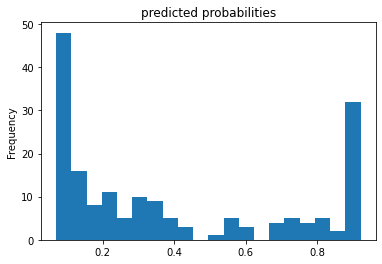

In [32]:
pred_dicts = list(bt_estor.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
plt.show()

In [33]:
# (TF_FEATURE_CREATION) Call Input Functions - for serving input
pred_input_fn = make_input_fn(titanic_test_data, shuffle=False, n_epochs=1)

pred_dicts = list(bt_estor.predict(pred_input_fn))
pred_outputs = pd.Series([pred['class_ids'][0] for pred in pred_dicts])

In [34]:
# Save output
from datetime import datetime
timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

output = pd.DataFrame({'PassengerId': titanic_test_data.PassengerId, 'Survived': pred_outputs})
output.to_csv('submission_tf_btc' +  '.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
